# <div align="center">UPb-Timeseries</div>
## <div align="center">Python code for displaying U-Pb timeseries data from Element2 txt files</div>
#### <div align="center">Megan Mueller</div>
##### <div align="center">Please cite the accompanying article under consideration in Geochronology:</div>
<div align="center">Mueller et al., https://doi.org/10.5194/egusphere-2023-1293 </div>



<br><div align="center">Version 1.1.2</div>

# Overview 
This notebook aims to display U-Pb timeseries data. Data inputs are .txt files from Element2, described below, but the code can be modified for other formats. All txt files of interest should be in the same folder.

### File format

*Rows:*
- Row 1: Header

- Rows 2-6: text or empty. Can be adjusted if more/less header rows exist.

- Rows 7+: data

*Columns:*

- Column 1: Time (s)

- Column 2: 206Pb (cps)

- Column 3: 207Pb (cps)

- Column 4: 208Pb (cps)

- Column 5: 232Th (cps)

- Column 6: 238U (cps)

- Column 7: 206/238 ratio

- Column 8: 208/232 ratio

- Column 9: 207/206 ratio

<a id='Section1'></a>
# 1. Import Data and Set-Up


### 1.1 Install Python Packages and Import Libraries

In [1]:
### Install Python packages
# Run to see if installed, if not, will install
# Only need to install once

import importlib
from subprocess import run

def install_if_not_installed(package_name):
    try:
        importlib.import_module(package_name)
        print(f"Package {package_name} is already installed.")
    except ImportError:
        print(f"Installing package: {package_name}")
        run(['pip', 'install', package_name], check=True)
        print(f"Installed package: {package_name}")

install_if_not_installed("pandas") # Install pandas
install_if_not_installed("numpy") # Install numpy
install_if_not_installed("matplotlib") # Install matplotlib
install_if_not_installed("tabulate") # Install tabulate
install_if_not_installed("easygui") # Install easygui

Package pandas is already installed.
Package numpy is already installed.
Package matplotlib is already installed.
Package tabulate is already installed.
Package easygui is already installed.


In [2]:
### Load libraries

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import easygui
%matplotlib inline
%matplotlib notebook


### 1.2 Initial File Parameters

The provided example dataset includes all R10 U-Pb analyses from analytical run 21RtF from Mueller et al., in review: 

ExampleDataset-UPbTimeseries-Muelleretal-21RtF-R10

In [3]:
# SET THESE VALUES
background = 7.3  # seconds of background measurement before first values in integration window. Here, 7.3 seconds. Can find this value in txt files, where isotope CPS increase dramatically at start of lasing
washout = 15  # seconds of washout + pause. Sets the x-axis distance between analyses.

# Set the folder path where txt files are located
folder_path = r'C:\Users\megan\Dropbox\rutile\MATLAB\Timeseries\Data\071321_MM_21RtF'

### 1.3 Options for Plotting
3 options for what to plot. Run one of the below cells. Change *'keyword'* to the desired label (e.g., specific std, unknown, inclusion/excludion criteria).

- Option 1: Load all txt files that include the keyword
- Option 2: Load all ALL txt files in the folder
- Option 3: Load all files that exclude keyword(s)

In [11]:
# Option 1: Get a list of all txt files in the folder that include the keyword
# change code for variable 'keyword'

# Label for criteria, to be included in plot title and filename
keyword = 'R10-0' # display R10 analyses 01 to 09

# Get a list of all ".txt" files in the folder
all_files = glob.glob(os.path.join(folder_path, '*.txt'))

# Extract only the file names without the full path
file_names = [os.path.basename(file) for file in all_files]

# Option 1: Get a list of all txt files in the folder that include the keyword
include_keyword = keyword  # Change to the desired keyword
files_to_include = [file for file in file_names if include_keyword in file]

# Sort files_to_include based on the "date modified" information
sorted_files = sorted(files_to_include, key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))

# Display the number of files
print(f'Number of files: {len(sorted_files)}')

# Print the list of sorted files
print('\nFiles loaded:')
print(sorted_files)

Number of files: 9

Files loaded:
['R10-01.TXT', 'R10-02.TXT', 'R10-03.TXT', 'R10-04.TXT', 'R10-05.TXT', 'R10-06.TXT', 'R10-07.TXT', 'R10-08.TXT', 'R10-09.TXT']


In [5]:
# Option 2: Get a list of ALL txt files in the folder
# change code for variable 'keyword'

# Label for criteria, to be included in plot title and filename
keyword = 'AllFiles'

# Get a list of all ".txt" files in the folder
all_files = glob.glob(os.path.join(folder_path, '*.txt'))

# Extract only the file names without the full path
file_names = [os.path.basename(file) for file in all_files]

# Sort file_names based on the "date modified" information
sorted_files = sorted(file_names, key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))

# Display the number of files
print(f'Number of files: {len(sorted_files)}')

# Print the list of sorted files
print('\nFiles loaded:')
print(sorted_files)

Number of files: 487

Files loaded:
['R10-01.TXT', '9826J-01.TXT', 'Krag-01.TXT', 'R10-02.TXT', 'R10-03.TXT', 'R10-04.TXT', 'R10-05.TXT', 'Wod-01.TXT', '16SKY37-01.TXT', '9826J-02.TXT', 'Krag-02.TXT', 'R10-06.TXT', 'R10-07.TXT', 'R10-08.TXT', 'Wod-02.TXT', '16SKY37-02.TXT', '16SKY37-03p.TXT', '16SKY37-04.TXT', '16SKY37-05.TXT', '16SKY37-06.TXT', '16SKY37-07.TXT', '16SKY37-08.TXT', '16SKY37-09.TXT', '16SKY37-10.TXT', '16SKY37-11.TXT', '16SKY37-12.TXT', '9826J-03.TXT', 'R10-09.TXT', '16SKY37-13.TXT', '16SKY37-14.TXT', '16SKY37-15.TXT', '16SKY37-16.TXT', 'Krag-03.TXT', 'R10-10.TXT', '16SKY37-17.TXT', '16SKY37-18.TXT', '16SKY37-19.TXT', '16SKY37-20.TXT', '16SKY37-21.TXT', '16SKY37-22.TXT', '16SKY37-23.TXT', '16SKY37-24.TXT', 'R10-11.TXT', 'Wod-03.TXT', '16SKY37-25.TXT', '16SKY37-26.TXT', '16SKY37-27.TXT', '16SKY37-28.TXT', 'R10-12.TXT', '16SKY37-29.TXT', '16SKY37-30i.TXT', '16SKY37-31.TXT', '16SKY37-32.TXT', '9826J-04.TXT', '16SKY37-33.TXT', '16SKY37-34.TXT', '16SKY37-35.TXT', '16SKY37-36.

In [6]:
# Option 3: Get a list of all TXT files in the folder that exclude keywords
# change code to set 'exclude_keywords' and 'keyword'

# Label for criteria, to be included in plot title (**not a criteria for selecting filenames here)
keyword = 'NoStds'

# Get a list of all ".txt" files in the folder
all_files = glob.glob(os.path.join(folder_path, '*.txt'))

# Extract only the file names without the full path
file_names = [os.path.basename(file) for file in all_files]

# Exclude files with filenames that include certain text (i.e. 'R10')
exclude_keywords = ['Wod', 'Krag', 'R10', 'LJ0408', '9826J'] 
files_to_include = [file for file in file_names if all(keyword not in file for keyword in exclude_keywords)]

# Sort files_to_include based on the "date modified" information
sorted_files = sorted(files_to_include, key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))

# Display the number of files
print(f'Number of files: {len(sorted_files)}')

# Print the list of sorted files
print('\nFiles loaded:')
print(sorted_files)

Number of files: 377

Files loaded:
['16SKY37-01.TXT', '16SKY37-02.TXT', '16SKY37-03p.TXT', '16SKY37-04.TXT', '16SKY37-05.TXT', '16SKY37-06.TXT', '16SKY37-07.TXT', '16SKY37-08.TXT', '16SKY37-09.TXT', '16SKY37-10.TXT', '16SKY37-11.TXT', '16SKY37-12.TXT', '16SKY37-13.TXT', '16SKY37-14.TXT', '16SKY37-15.TXT', '16SKY37-16.TXT', '16SKY37-17.TXT', '16SKY37-18.TXT', '16SKY37-19.TXT', '16SKY37-20.TXT', '16SKY37-21.TXT', '16SKY37-22.TXT', '16SKY37-23.TXT', '16SKY37-24.TXT', '16SKY37-25.TXT', '16SKY37-26.TXT', '16SKY37-27.TXT', '16SKY37-28.TXT', '16SKY37-29.TXT', '16SKY37-30i.TXT', '16SKY37-31.TXT', '16SKY37-32.TXT', '16SKY37-33.TXT', '16SKY37-34.TXT', '16SKY37-35.TXT', '16SKY37-36.TXT', '16SKY37-37.TXT', '16SKY37-38.TXT', '16SKY37-39.TXT', '16SKY37-40.TXT', '16SKY37-41p.TXT', '16SKY37-42.TXT', '16SKY37-43.TXT', '16SKY37-44.TXT', '16SKY37-45.TXT', '16SKY37-46.TXT', '16SKY37-47.TXT', '16SKY37-48.TXT', '16SKY37-49.TXT', '16SKY37-50.TXT', '16SKY37-51.TXT', '16SKY37-52.TXT', '16SKY37-53.TXT', '16SKY

# 2. Plot timeseries and save as PDF

Creat a plot of the loaded files (based on the most recent option run in Section 1.3). Assumes txt files are tab searated, if not, change instances of '\t' to ',' for CSV, for example. Txt file structure: 
- the line labels are taken from Row 1
- the 'skiprows' parameter is set based on how many headers rows before data (here, 6 rows are skipped)
- Columns are as follows: 
    - Column 1: Time (s)

    - Column 2: 206Pb (cps)

    - Column 3: 207Pb (cps)

    - Column 4: 208Pb (cps)

    - Column 5: 232Th (cps)

    - Column 6: 238U (cps)

    - Column 7: 206/238

    - Column 8: 208/232

    - Column 9: 207/207

<IPython.core.display.Javascript object>


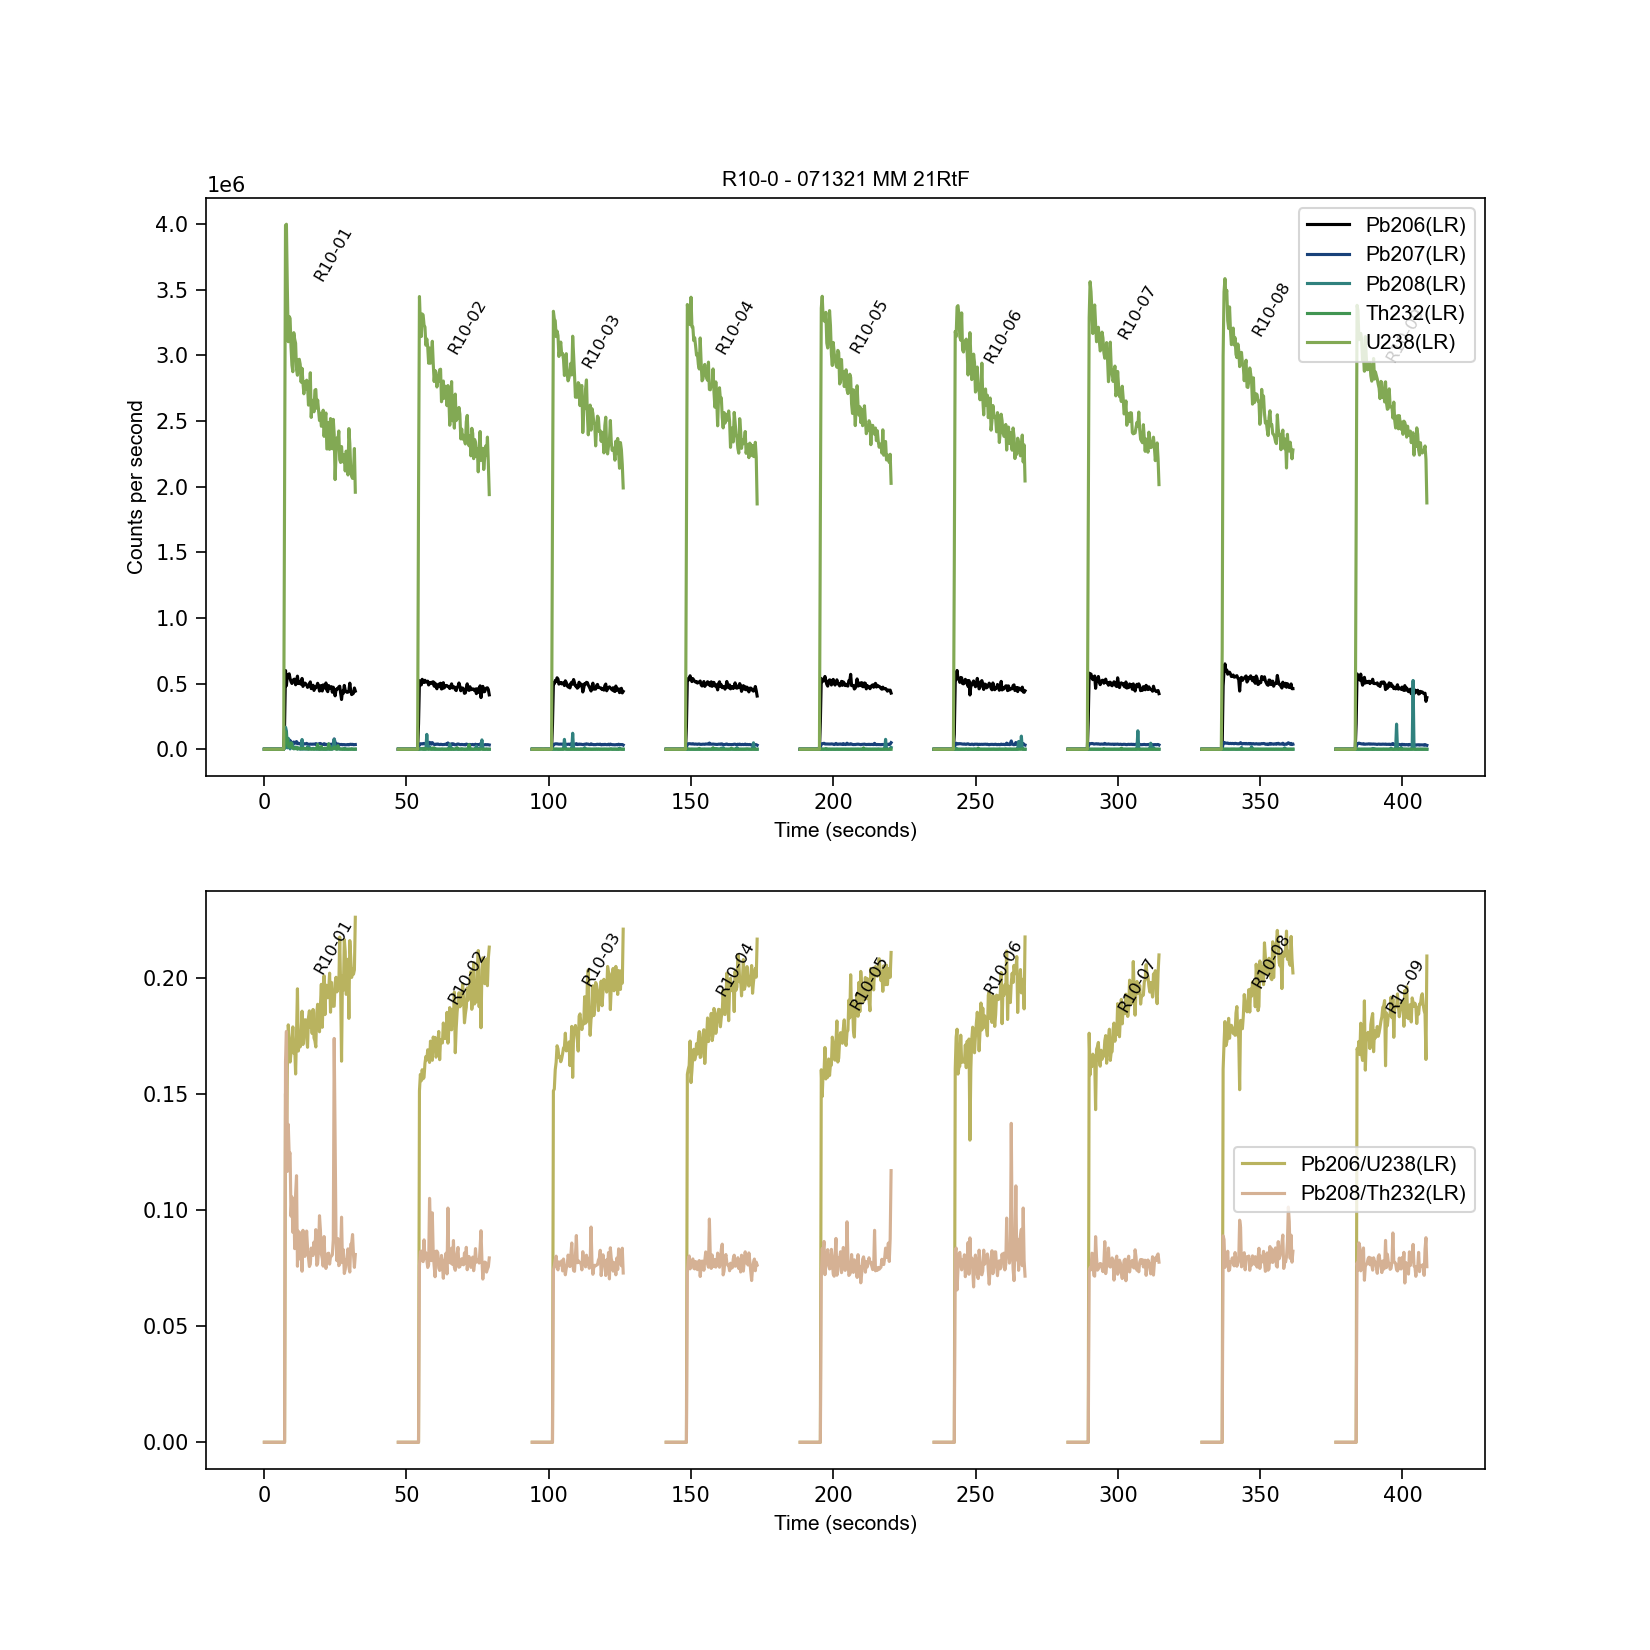

In [12]:
### Plot timeseries

plt.close()
plt.figure(figsize=(11,11))

# Initialize a variable to keep track of the end time
end_time = 0

# Extract the final folder name from the path
folder_name = os.path.basename(folder_path)
folder_name2 = folder_name.replace('_', ' ')  # Replace underscores with spaces

# Read the data from the first file to get the header labels
first_file = os.path.join(folder_path, sorted_files[0])
with open(first_file, 'r') as f:
    labels = f.readline().strip().split('\t')  # Assuming the columns are tab-separated

# Define plot colors
line_colors = plt.colormaps['tab10'].colors
colors = iter(cm.gist_earth(np.linspace(0, 1, 8)))
color_list = list(colors)

# Loop through each file and read the data
for file_name in sorted_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, file_name)

    # Read the data from the TXT file, skipping 6 rows
    data = pd.read_csv(file_path, sep='\t', skiprows=6, header=None)

    # Extract columns 1, 2, 3, 4, 5, 6, 7, 8, and 9
    col1 = data.iloc[:, 0] # Column 1: Time (s)
    col2 = data.iloc[:, 1] # Column 2: 206Pb (cps)
    col3 = data.iloc[:, 2] # Column 3: 207Pb (cps)
    col4 = data.iloc[:, 3] # Column 4: 208Pb (cps)
    col5 = data.iloc[:, 4] # Column 5: 232Th (cps)
    col6 = data.iloc[:, 5] # Column 6: 238U (cps)
    col7 = data.iloc[:, 6] # Column 7: 206/238
    col8 = data.iloc[:, 7] # Column 8: 208/232
    col9 = data.iloc[:, 8] # Column 9: 207/207

    # Create and populate columns 10 and 11 based on conditions
    col10 = np.zeros_like(col1)
    col11 = np.zeros_like(col1)

    # Check the condition for each row
    condition = col1 >= background

    # Populate columns 10 and 11 based on conditions
    col10[condition] = col7[condition]
    col11[condition] = col9[condition]

    # Adjust time values based on the end time of the previous file
    col1 = col1 + end_time
    
    # Plot columns 2-6 with lines only in the top subplot
    plt.subplot(2, 1, 1)
    plt.plot(col1, col2, '-', color=color_list[0])  # Blue
    plt.plot(col1, col3, '-', color=color_list[1])  # Orange
    plt.plot(col1, col4, '-', color=color_list[2])  # Green
    plt.plot(col1, col5, '-', color=color_list[3])  # Red
    plt.plot(col1, col6, '-', color=color_list[4])  # Purple
    plt.text(col1.iloc[-1], max([col2.max(), col3.max(), col4.max(), col5.max(), col6.max()]),
             file_name[:-4], verticalalignment='top', horizontalalignment='right', rotation=60, fontsize=8) # Add sample labels

    # Plot columns 10 and 11 with lines only in the bottom subplot
    plt.subplot(2, 1, 2)
    plt.plot(col1, col10, '-', color=color_list[5])  # Blue
    plt.plot(col1, col11, '-', color=color_list[6])  # Orange
    plt.text(col1.iloc[-1], max([col10.max(), col11.max()]),
             file_name[:-4], verticalalignment='top', horizontalalignment='right', rotation=60, fontsize=8) # Add sample labels

    # Add 15 seconds to the end time for the gap between files
    end_time = col1.iloc[-1] + washout

# Customize plot labels for the top subplot
plt.subplot(2, 1, 1)
plt.xlabel('Time (seconds)', fontsize=10, fontname='Arial')
plt.ylabel('Counts per second', fontsize=10, fontname='Arial')
legend_labels_top = labels[1:6]
plt.legend(legend_labels_top, loc='best', fontsize=8, prop={'family': 'Arial'})
plt.title(f'{keyword} - {folder_name2}', fontsize=10, fontname='Arial')
plt.tick_params(axis='both', direction='out', length=5)
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()


# Customize plot labels for the bottom subplot
plt.subplot(2, 1, 2)
plt.xlabel('Time (seconds)', fontsize=10, fontname='Arial')
legend_labels_bottom = labels[6:8]
plt.legend(legend_labels_bottom, loc='best', fontsize=8, prop={'family': 'Arial'})
plt.tick_params(axis='both', direction='out', length=5)
plt.gca().xaxis.tick_bottom()
plt.gca().yaxis.tick_left()

# Set the tick direction to 'out' for both subplots
plt.gca().tick_params(axis='both', direction='out')
plt.subplot(2, 1, 1).tick_params(axis='both', direction='out')


# Save the plot as a PDF
#plt.gcf().set_size_inches(11, 8.5)
#plt.savefig(os.path.join(os.getcwd(), f'{folder_name}-{keyword}.pdf'), format='pdf', bbox_inches='tight')

In [8]:
### Run to save figure
# Run immediately after generating figure or might save a different figure instead
user_input = input("\033[1mDo you want to save the plot? (yes/no): \033[0m\n yes/no is case sensitive \n If yes, will open window to save \n")

if user_input.lower() == 'yes':
    # Ask the user for the folder and filename to save the file
    file_path = easygui.filesavebox(
        default=os.path.join(folder_path, f"UPbTimeseries_{keyword}_v1.pdf"),
        filetypes=["*.pdf"],
        title="Select Folder and File Name to Save PDF File"
    )

    # If the user selected a file path, save the figure
    if file_path:
        plt.savefig(file_path, format="pdf")
        print("\033[1mFigure saved successfully at:\033[0m", file_path)
    else:
        print("\033[1mFigure not saved.\033[0m")
else:
    print("\033[1mFigure not saved.\033[0m")

Do you want to save the plot? (yes/no): 
 yes/no is case sensitive 
 If yes, will open window to save 
no
Figure not saved.
